<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/baseball_pitch_type_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learn Optuna With Baseball Data: Classifying Pitch Types
Machine learning is a great way to get accurate predictions for complex problems but to really get the most out of your models, you will need to "tune" -- or adjust your hyperparameter tuning variables. You can manually adjust things (like the number of estimators in your random forest model) or use things like "Grid Search", which looks over a predefined combination of parameters. These methods can take a lot of effort (inputting different random values) or take a long time (all the different combinations). Optuna can help with less effort and a shorter amount of time.  

Let's use a baseball example: classifying pitch types. In baseball, a pitcher can throw a variety of pitch types -- some are fast, some have hard-to-predict movement. Combinations of these characteristics lead to the differences between pitches like a "fastball" and a "slider". The problem is actually harder than it seems -- many different pitchers throw the ball differently, so it is hard to distinguish some pitch types from others (i.e. some people throw a curveball but that may look like another pitcher's slider).  

We can use machine learning to classify these pitch types. We can go one step further and tune our model with `optuna` to produce greater accuracy in our pitch type classifications.  

In [ ]:
# install pybaseball to get baseball data
# install optuna

!pip install pybaseball -q
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# for data
import pybaseball as bb

# to prepare data for modeling
import pandas as pd

# import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score

# import optuna
import optuna

# for exploratory analysis
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# download 3 months of pitching data
df = bb.statcast(start_dt='2022-04-01', end_dt='2022-07-01')

# drop any pitch types that are null
df = df.dropna(subset=['pitch_type'])

# reset index (for model preparation)
df = df.reset_index(drop=True)

# print the shape of the data
df.shape

This is a large query, it may take a moment to complete


/usr/local/lib/python3.8/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 92/92 [02:55<00:00,  1.91s/it]


(346012, 93)

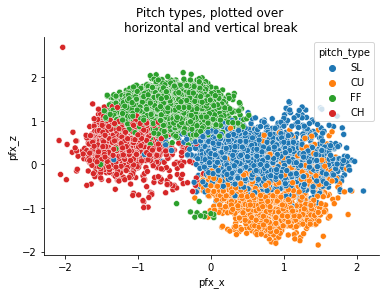

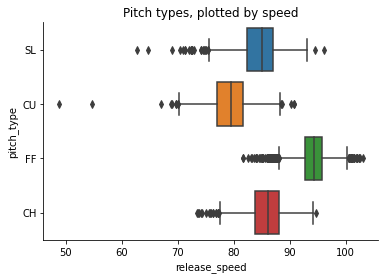

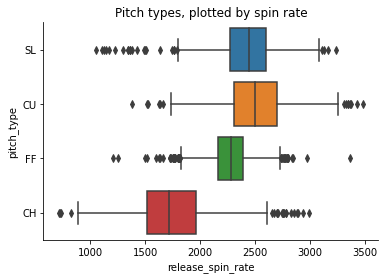

In [ ]:
# subset a smaller amount of data
# 10k rows, 4 pitch types and right-handed pitchers
df_plt = (df
          .loc[(df['pitch_type']
                .isin(['FF','SL','CU', 'CH'])) &
               (df['p_throws']=='R')]
          .sample(10000))

# plot the "break" of the pitch,
# break is the difference between ideal physics and
# earth physics (aka gravity + air resistance)
sns.scatterplot(data=df_plt,
                x='pfx_x',
                y='pfx_z',
                hue='pitch_type')
sns.despine()
plt.title('Pitch types, plotted over \nhorizontal and vertical break')
plt.show()

# plot the speed of a pitch
sns.boxplot(data=df_plt,
            x='release_speed',
            y='pitch_type',
            orient='h')
sns.despine()
plt.title('Pitch types, plotted by speed')
plt.show()

# plot the spin rate of a pitch
sns.boxplot(data=df_plt,
            x='release_spin_rate',
            y='pitch_type',
            orient='h')
sns.despine()
plt.title('Pitch types, plotted by spin rate')
plt.show()

We can see from our exploratory data analysis that break, speed, and spin rate all can differentiate pitch types. Let's use these features for our model in order to classify pitch types.  

In [ ]:
# define lefty pitchers and righty pitchers
df['is_lefty'] = 0
df.loc[df['p_throws'] == 'L', 'is_lefty'] = 1

# define the features (break, spin, speed) and the target variable (pitch types)
id_feats = ['player_name', 'pitcher', 'pitch_type']
feats = ['is_lefty', 'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']
target = 'pitch_type_code'

# drop any values that are null
subset = df.loc[df['pitch_type']!='KN', id_feats+feats+[target]].dropna()

# turn pitch types into numerical values
subset['pitch_type_code'] = subset['pitch_type'].astype('category').cat.codes

# split the data so 50k pitches are in the test set and 100k pitches are in the train set
test = subset.sample(50000)
train = subset.loc[~subset.index.isin(test.index.values)].sample(100000)


In [ ]:
# in order to know what pitch types are what, let's create a mapping system
# so we can change the coded pitches back to the pitch type names
map_pitch_types = (subset
                   .loc[:, ['pitch_type', 'pitch_type_code']]
                   .drop_duplicates()
                   .set_index('pitch_type_code')
                   .to_dict()['pitch_type'])

# list all the unique pitch type names
pitch_types = subset['pitch_type'].unique()

# print the pitch type names alongside the pitch codes
subset.loc[:, ['pitch_type', 'pitch_type_code']].drop_duplicates().sort_values('pitch_type_code')

,pitch_type,pitch_type_code
81,CH,0
221,CS,1
144,CU,2
3604,EP,3
2759,FA,4
4,FC,5
12,FF,6
8,FS,7
0,KC,8
23,SI,9


In [ ]:
# train a logistic regression
logr = LogisticRegression()

# fit the model
logr.fit(train.loc[:, feats], train[target])

# predict probabilities of each pitch type
_df = (pd
       .DataFrame(logr.predict_proba(test.loc[:, feats]),
                  index=test.index)
       .rename(columns=map_pitch_types))

# append the data back to the test dataset
test = pd.concat([test,_df], axis=1)

# use the highest probability pitch type as the estimated pitch type
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# check data quality
test.sample(10)

,player_name,pitcher,pitch_type,is_lefty,release_speed,release_spin_rate,pfx_x,pfx_z,pitch_type_code,CH,...,CU,EP,FA,FC,FF,FS,KC,SI,SL,pitch_type_pred
103008,"Jackson, Zach",667427,FF,0,96.9,2168,-0.69,1.66,6,1.482113e-01,...,0.001493,0.000496,0.001240,0.034187,0.465586,0.016067,0.008905,0.303592,0.020162,FF
120074,"Senzatela, Antonio",622608,FF,0,96.1,2150,-0.21,0.98,6,1.507164e-01,...,0.001597,0.000529,0.001311,0.035215,0.457887,0.016629,0.009301,0.305719,0.021030,FF
120216,"Ober, Bailey",641927,CH,0,82.6,1669,-1.27,0.24,0,3.756948e-01,...,0.000387,0.000856,0.001728,0.014661,0.240127,0.021941,0.004981,0.334408,0.005050,CH
176829,"Stripling, Ross",548389,CH,0,83.1,1736,-1.31,0.69,0,2.991233e-01,...,0.000755,0.000969,0.002014,0.021529,0.300507,0.023187,0.007112,0.335686,0.008940,SI
265866,"Severino, Anderson",644429,CU,1,79.4,2650,-0.98,-1.12,2,8.271082e-06,...,0.387862,0.000030,0.000092,0.039823,0.016543,0.000133,0.009958,0.000518,0.545029,SL
144442,"Solomon, Jared",676660,SL,0,88.6,2322,0.44,0.08,10,1.124723e-02,...,0.048504,0.000623,0.001666,0.127966,0.420463,0.008832,0.033532,0.085642,0.261459,FF
221686,"Anderson, Tyler",542881,FF,1,88.6,2165,0.75,1.62,6,4.486003e-02,...,0.013975,0.000853,0.002132,0.089596,0.523272,0.015397,0.024569,0.180218,0.105023,FF
132946,"Freeland, Kyle",607536,FF,1,89.9,2420,0.58,1.48,6,5.444670e-03,...,0.067729,0.000447,0.001248,0.130561,0.367655,0.005964,0.032599,0.055407,0.332902,FF
304485,"Lyles, Jordan",543475,CH,0,87.8,1533,-1.28,0.71,0,6.908908e-01,...,0.000008,0.000208,0.000395,0.001518,0.067687,0.009479,0.000522,0.229037,0.000211,CH
92283,"Thornton, Trent",663423,CU,0,80.7,2857,0.63,-1.1,2,5.609864e-07,...,0.480196,0.000006,0.000021,0.019309,0.004510,0.000022,0.004457,0.000073,0.491404,SL


In [ ]:
# produce accuracy and log loss metrics to evaluate model performance
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.53872, 5.151073846117406)

This logistic regression classifier produced about 54% accuracy, with a log loss of 5.15. We know from the EDA that some of these features are not linear (i.e. break) so it is possible that a linear model (like logistic regression) would have difficulties handling the nonlinear features.

Let's try a nonlinear model, random forest.

In [ ]:
# drop old preds
test = test.drop(pitch_types, axis=1)

In [ ]:
rf = RandomForestClassifier()
rf.fit(train.loc[:, feats], train[target])
_df = (pd
       .DataFrame(rf.predict_proba(test.loc[:, feats]),
                  index=test.index)
       .rename(columns=map_pitch_types))
test = pd.concat([test,_df], axis=1)
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

In [ ]:
test.sample(10)

,player_name,pitcher,pitch_type,is_lefty,release_speed,release_spin_rate,pfx_x,pfx_z,pitch_type_code,pitch_type_pred,...,CS,CU,EP,FA,FC,FF,FS,KC,SI,SL
344819,"Brash, Matt",666374,FF,0,98.0,2246,-0.83,1.35,6,FF,...,0.0,0.00,0.0,0.0,0.00,0.98,0.00,0.00,0.02,0.00
170512,"Junis, Jakob",596001,SI,0,89.5,2127,-1.46,0.46,9,CH,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.43,0.00
66871,"Koenig, Jared",657649,SI,1,88.0,2113,0.74,0.75,9,SI,...,0.0,0.01,0.0,0.0,0.22,0.09,0.00,0.00,0.52,0.11
209222,"Rogers, Taylor",573124,SI,1,93.6,2130,1.64,0.9,9,SI,...,0.0,0.00,0.0,0.0,0.00,0.11,0.00,0.00,0.89,0.00
289305,"Kittredge, Andrew",552640,SL,0,88.3,2678,0.86,0.23,10,SL,...,0.0,0.00,0.0,0.0,0.13,0.00,0.00,0.00,0.00,0.87
101261,"Steele, Justin",657006,FF,1,91.9,2537,-0.38,0.9,6,FF,...,0.0,0.00,0.0,0.0,0.10,0.83,0.00,0.00,0.02,0.05
184921,"Cueto, Johnny",456501,FC,0,86.1,2208,0.11,0.76,5,SL,...,0.0,0.00,0.0,0.0,0.17,0.00,0.00,0.00,0.00,0.83
237824,"Manoah, Alek",666201,CH,0,85.6,1794,-1.16,0.57,0,CH,...,0.0,0.00,0.0,0.0,0.00,0.00,0.15,0.00,0.15,0.00
15132,"Morton, Charlie",450203,CU,0,81.8,3159,1.58,-1.05,2,CU,...,0.0,0.82,0.0,0.0,0.00,0.00,0.00,0.05,0.00,0.13
46208,"Pallante, Andre",669467,SL,0,88.4,2388,0.44,0.05,10,SL,...,0.0,0.00,0.0,0.0,0.29,0.00,0.00,0.00,0.00,0.71


In [ ]:
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.84454, 31.73450498863242)

The random forest model clearly is an improvement in accuracy over the linear model. Although the loss is greater (aka worse), the accuracy is much better. The loss may be poor because the classification is much stronger for perhaps a wrong pitch type (think: someone's slider being classified as a curveball, like I mentioned in the intro.)  

Let's use `optuna` to try and improve our accuracy even further by "smart" tuning our model.  

In [ ]:
# drop old preds
test = test.drop(pitch_types, axis=1)

In [ ]:
def tune(trial):
  n_estimators=trial.suggest_int('n_estimators', 10, 500)
  max_features=trial.suggest_categorical('max_features', ["sqrt", "log2"])
  model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
  model.fit(train.loc[:, feats], train[target])
  _df = (pd
        .DataFrame(model.predict_proba(test.loc[:, feats]),
                    index=test.index)
        .rename(columns=map_pitch_types))
  _df['pitch_type_pred'] = _df.loc[:, pitch_types].idxmax(axis=1)
  acc = accuracy_score(test['pitch_type'], _df['pitch_type_pred'])
  return acc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(tune, n_trials=3)

[I 2023-01-18 05:57:42,329] A new study created in memory with name: no-name-c61807f5-3425-4390-a503-3e8a1d7b9d13
[I 2023-01-18 05:59:36,129] Trial 0 finished with value: 0.84572 and parameters: {'n_estimators': 447, 'max_features': 'log2'}. Best is trial 0 with value: 0.84572.
[I 2023-01-18 06:00:45,965] Trial 1 finished with value: 0.84658 and parameters: {'n_estimators': 305, 'max_features': 'log2'}. Best is trial 1 with value: 0.84658.
[I 2023-01-18 06:02:43,814] Trial 2 finished with value: 0.8457 and parameters: {'n_estimators': 497, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.84658.


In [ ]:
study.best_params

{'n_estimators': 305, 'max_features': 'log2'}

In [ ]:
rf = RandomForestClassifier(n_estimators=study.best_params['n_estimators'],
                            max_features=study.best_params['max_features'])
rf.fit(train.loc[:, feats], train[target])
_df = (pd
       .DataFrame(rf.predict_proba(test.loc[:, feats]),
                  index=test.index)
       .rename(columns=map_pitch_types))
test = pd.concat([test,_df], axis=1)
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

In [ ]:
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.84534, 30.881000246323204)

The accuracy improvements are very modest, but with different parameters to tune over (we only tuned over `n_estimators` and `max_features`) or a different model type (e.g. GBM, SVM) or even more features (release point, balls + strikes, etc), we could possibly further improve our model accuracy.

If you like this notebook and other data science or sports analytics content, check out the YT channel and the Twitch stream

https://twitch.tv/nickwan_datasci  
https://youtube.com/NickWan  